# Deep Mixture Cure Model: Recurrent Neural Network
# Contents
<a href='#LoadingLibraries'>1. Load all neccessary libraries</a><br/>
<a href='#EDA'>2. Explanatory Data Analysis</a><br/>
<a href='#ChooseFeatures'>3. Choose Features from Earlier Section or External Files</a><br/>
<a href='#ImputeWinsorizeStandardize'>4. Imputation, Winsorization, Standardization</a><br/>
<a href='#TrainTestModels'>5. Train & Test the Models</a><br/>
<a href='#FeatureAnalysis'>6. Analyze Model Features Importance and their Correlation</a><br/>
<a href='#ScoreMapping'>7. Build Score Mapping Functions</a><br/>
<a href='#CreateModelPickle'>8. Create Deployable Pickle File</a><br/>
<a href='#ModelComparison'>9. Compare Model Scores against each other</a><br/>
<a href='#AnalyzeFilter'>10. Analyze the impact of various filters on training data</a><br/>
<a href='#FeatureSelectionGAXGBoost'>11. Feature Selection via Genetic Algorithm - xgboost</a><br/>
<a href='#FeatureSelectionGAXLogReg'>12. Feature Selection via Genetic Algorithm - logreg </a><br/>

# Load all neccessary libraries and data<a id='LoadingLibraries'></a>

In [1]:
import pandas as pd
import numpy as np

# load data and train-test split
from sklearn.model_selection import train_test_split
import random
from random import randint

import lifelines
from lifelines.plotting import plot_lifetimes
from lifelines.utils import to_long_format

import matplotlib.pyplot as plt

random.seed(116)

loan_m = pd.read_csv('../mortgage/mortgage.csv')
loan_m['term']  = loan_m.time - loan_m.orig_time 
loan_m['t']     = loan_m.time - loan_m.first_time
loan_m['label'] = [l if l == 1 else 0 for l in loan_m['status_time'] ]
loan_m['payoff_label'] = loan_m['payoff_time']
print(loan_m.shape)

(622489, 27)


# Explanatory Analysis of Data<a id='EDA'></a>

In [2]:
#duplicated rows: duplicates of all columns
print(loan_m[loan_m.duplicated(keep=False)].shape)

#duplicates of id and time
loan_m[loan_m.duplicated(subset = ['id', 'time'], keep = False)]

(610, 27)


,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,term,t,label,payoff_label
28782,3014,24,19,21,139,150010.91,67.902429,8.10,223.75,3.121195,...,80.0,8.09,191.42,0,0,0,5,3,0,0
28783,3014,24,21,21,142,346345.09,73.510401,8.35,223.75,3.121195,...,78.9,8.35,208.86,0,0,0,3,3,0,0
28784,3014,25,19,21,139,149686.42,66.995024,8.10,226.29,2.899137,...,80.0,8.09,191.42,0,0,0,6,4,0,0
28785,3014,25,21,21,142,345676.41,72.544949,8.35,226.29,2.899137,...,78.9,8.35,208.86,0,0,0,4,4,0,0
28786,3014,26,19,21,139,149355.31,67.200218,8.10,225.10,2.151365,...,80.0,8.09,191.42,0,0,0,7,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540793,42514,23,21,23,141,233505.32,84.528241,7.79,221.91,2.987109,...,90.0,0.00,208.86,0,0,0,2,0,0,0
540794,42514,24,21,23,141,131750.00,79.343464,6.56,223.75,3.121195,...,85.0,6.56,208.86,0,0,0,3,1,0,0
540795,42514,24,21,23,141,233000.93,83.652040,7.79,223.75,3.121195,...,90.0,0.00,208.86,0,0,0,3,1,0,0
540796,42514,25,21,23,141,131750.00,78.452870,6.56,226.29,2.899137,...,85.0,6.56,208.86,0,0,0,4,2,0,0


In [3]:
#deduplicate of dataset
print('initial shape of data: ' + str(loan_m.shape))
loan_m = loan_m.drop_duplicates(keep='first', ignore_index=True)
print('after dropping total duplication: ' + str(loan_m.shape))

loan_m = loan_m.drop_duplicates(subset = ['id', 'time'], keep = 'first', ignore_index = True)
print('after dropping id&time duplication: ' + str(loan_m.shape))

initial shape of data: (622489, 27)
after dropping total duplication: (622184, 27)
after dropping id&time duplication: (622150, 27)


Text(0.5, 0, 'Terms from loan recognition')

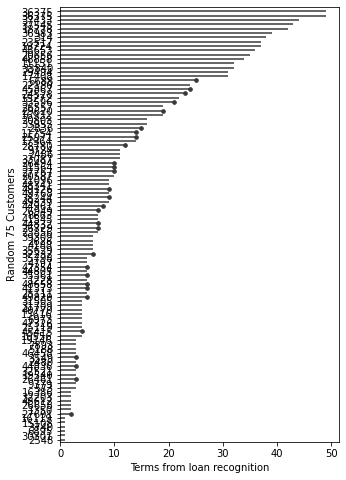

In [4]:
# plot the observations: birth event the initial recognition of loan 
term_df = loan_m.groupby(['id']).agg({'t': [min, max, len], 
'label': max})

plt.figure(figsize=(5,8))
x  = [randint(0, 50000) for p in range(100)]
df = term_df.iloc[x]
plot_lifetimes(
    df.t.len,
    event_observed=df.label['max'],
    entry=df.t['min'],
    event_observed_color="#383838",
    event_censored_color="#383838",
    left_truncated=True,
)
plt.ylabel("Random 75 Customers")
plt.xlabel("Terms from loan recognition")

<AxesSubplot:xlabel='timeline'>

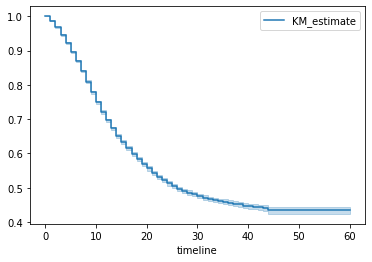

In [5]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = term_df.t.len
E = term_df.label['max']

kmf.fit(T, event_observed=E)
kmf.plot()

Text(0.5, 0, 'Terms from loan issued')

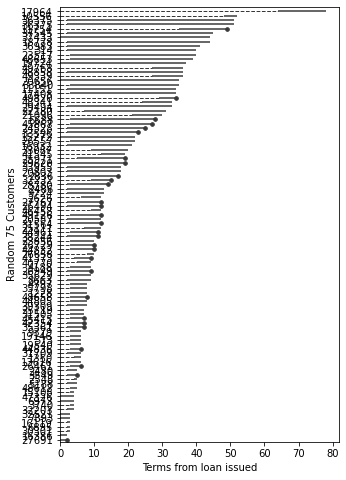

In [6]:
# plot the observations: birth event the issuing of loan 

term_df = loan_m.groupby(['id']).agg({'term': [min, max, len], 
'label': max})

plt.figure(figsize=(5,8))
df = term_df.iloc[x]
plot_lifetimes(
    df.term.len,
    event_observed=df.label['max'],
    entry=df.term['min'],
    event_observed_color="#383838",
    event_censored_color="#383838",
    left_truncated=True,
)
plt.ylabel("Random 75 Customers")
plt.xlabel("Terms from loan issued")

<AxesSubplot:xlabel='timeline'>

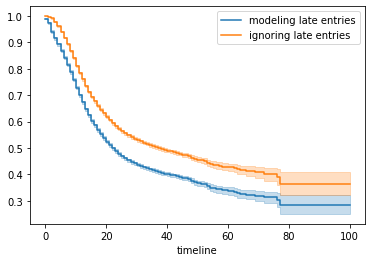

In [7]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(term_df.term['max'], event_observed=term_df.label['max'], entry=term_df.term['min'], label='modeling late entries')
ax = kmf.plot_survival_function()

kmf.fit(term_df.term['max'], event_observed=term_df.label['max'], label='ignoring late entries')
kmf.plot_survival_function(ax=ax)

In [6]:
#analysis of covariates which covariate to put inside the model

cols_leave = ['start', 'time', 'first_time', 'payoff_time', 'status_time', 'loan_time','label','default_time', 'payoff_label', 'total_obs_time', 'default_time', 'term', 'id', 't']  # 'LTV_time missing values'
cox_var = [var for var in loan_m.columns if not var in cols_leave]
print(cox_var)

orig_var = ['orig_time', 'mat_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', ]

varying_co = ['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time']

#['origination_time', 'maturity_time', 'interest_rate_time', 'balance_time', 'LTV_time','house_price_index_time', 'gdp_time', 'unemployment_rate_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'interest_rate_orig_time','house_price_index_orig_time']

['orig_time', 'mat_time', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']


In [7]:
#check duplicates
mask = (loan_m[loan_m.label == 1].groupby('id').count().time >1).values
print(loan_m[loan_m.label == 1].id.unique()[mask])

[]


In [8]:
id_exclude = loan_m[pd.isnull(loan_m[cox_var]).sum(axis = 1) >0].id.unique() 
print(id_exclude)#exclude these obs from dataset, missing values
mask = [id not in id_exclude for id in loan_m.id]
loan_m = loan_m[mask]
print(loan_m.shape)

[39722 39723 39724 39725 39726 39727 39728 39729 39730 39731 39732 39733
 39734 39735 39736 39737 39738 49658]
(621880, 27)


In [13]:
base_df = pd.DataFrame(loan_m.groupby('id').agg({'time':len, 'label': max}).reset_index())
base_df.columns = ['id', 'duration', 'label']
base_df = to_long_format(base_df, duration_col="duration")
print('if match: ' + str(loan_m[loan_m.label == 1].label.sum() == base_df.label.sum()))

if match: True


In [14]:
from lifelines.utils import add_covariate_to_timeline
data_cox_tv = loan_m[['id', 't'] + cox_var]
data_cox_tv = add_covariate_to_timeline(base_df, data_cox_tv, duration_col="t", id_col="id", event_col="label")

In [42]:
var_selection = ['orig_time', 'mat_time', 'balance_time', 'interest_rate_time', 'LTV_time',
'hpi_time', 'gdp_time', 'uer_time', 
#'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 
#'investor_orig_time',
'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 
'hpi_orig_time']
df = data_cox_tv[ var_selection + ['start', 'stop', 'id', 'label']]

In [43]:
# time varying covariate
from lifelines import CoxTimeVaryingFitter
cox_tv = CoxTimeVaryingFitter()
cph    = cox_tv.fit(df, id_col="id", event_col="label", start_col="start", stop_col="stop", show_progress=True, step_size=0.1)
#cph.plot_covariate_groups(covariates='mat_time', values=[50, 100], cmap='coolwarm')

Iteration 34: norm_delta = 0.00000, step_size = 1.00000, ll = -147733.29623, newton_decrement = 0.00000, seconds_since_start = 14.9Convergence completed after 34 iterations.


<AxesSubplot:xlabel='log(HR) (95% CI)'>

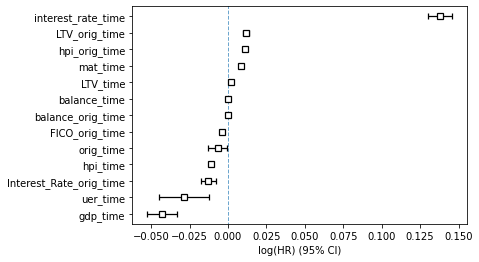

In [44]:
cph.print_summary() 
cph.plot()

In [1]:
import pandas as pd
df = pd.read_csv('tryout_loan.csv')

var_selection = ['first_time', 'orig_time', 'mat_time', 'balance_time', 'interest_rate_time', 'LTV_time', 
'hpi_time', 'gdp_time', 'uer_time', 
'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 
'hpi_orig_time']

from data_preprocess import *
feature_list = var_selection
data_process = preprocess_data(data_original =df[df.id<7], feature_list = var_selection,)
#the need to preprocess the data. we need mask of ranking, and other losses, data the match the need
a, b = data_process.construct_dataset()
DATA, MASK, data_mi, pat_info = data_process.preprocess()

In [7]:
label = DATA[2]
mask_ranking = MASK[1]

In [8]:
import tensorflow as tf
pi_l = tf.nn.softmax(tf.random.uniform(mask_ranking.shape, minval=0, maxval=1,dtype=tf.dtypes.float32,), axis= 1)

In [18]:
# compute ranking loss
    ### LOSS-FUNCTION 2 -- Ranking loss
def loss_Ranking(pi_l, mask_ranking, label, sigma1):
    '''
    compute ranking loss. 
    return: tf.tensor
    input(no competing risk):
        pi_l        : probability matrix of customers dim(customers, max_time)
        mask_ranking: 
    '''
    sigma1 = tf.constant(sigma1, dtype=tf.float32)
    label  = tf.constant(label,  dtype=tf.dtypes.float32)
    mask_ranking = tf.constant(mask_ranking,  dtype=tf.dtypes.float32)
    
    one_vector = tf.ones_like(label, dtype=tf.float32)
    tmp_e = tf.reshape(pi_l, shape = mask_ranking.shape)
    R = tf.matmul(tmp_e, tf.transpose(mask_ranking)) 
    diag_R = tf.reshape(tf.linalg.diag_part(R), [-1, 1]) # probability at actual event time
    R = tf.matmul(one_vector, tf.transpose(diag_R)) - R 
    print(R)
    R = tf.transpose(R)  
    T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(label)) - tf.matmul(label, tf.transpose(one_vector))))
    eta = tf.reduce_sum(tf.reduce_mean(T * tf.exp(-R/sigma1), axis=1, keepdims=True))
    return eta

In [31]:
loss_Ranking(pi_l, mask_ranking, label, 0.1)

tf.Tensor(
[[ 0.         -0.02037042  0.00264227  0.0520367  -0.00978077  0.00625092]
 [-0.01456052  0.         -0.01055601  0.01467758 -0.00584459 -0.02427942]
 [ 0.00705349  0.00109286  0.          0.04079825 -0.00202121  0.00860184]
 [-0.04161775 -0.01095472 -0.01724201  0.         -0.00900089 -0.03333962]
 [ 0.00682658 -0.00467972  0.01007806  0.03235394  0.         -0.00809985]
 [-0.02270436 -0.03209086 -0.02211773  0.02695882 -0.02811499  0.        ]], shape=(6, 6), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.435197>

In [5]:
#cols_leave = ['time', 'first_time', 'payoff_time', 'status_time', 'loan_time','label','default_time', 'payoff_label', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'total_obs_time', 'default_time']
#cox_var = [var for var in loan_m.columns if not var in cols_leave]
X = loan_m[cox_var].values
Y = loan_m.label.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=116, )

array([[ 1.0000e+00, -7.0000e+00,  1.1300e+02, ...,  6.9400e+01,
         9.2000e+00,  8.7030e+01],
       [ 1.0000e+00, -7.0000e+00,  1.1300e+02, ...,  6.9400e+01,
         9.2000e+00,  8.7030e+01],
       [ 1.0000e+00, -7.0000e+00,  1.1300e+02, ...,  6.9400e+01,
         9.2000e+00,  8.7030e+01],
       ...,
       [ 5.0000e+04,  1.6000e+01,  1.7700e+02, ...,  8.0000e+01,
         1.7500e+00,  1.6791e+02],
       [ 5.0000e+04,  1.6000e+01,  1.7700e+02, ...,  8.0000e+01,
         1.7500e+00,  1.6791e+02],
       [ 5.0000e+04,  1.6000e+01,  1.7700e+02, ...,  8.0000e+01,
         1.7500e+00,  1.6791e+02]])

100
60


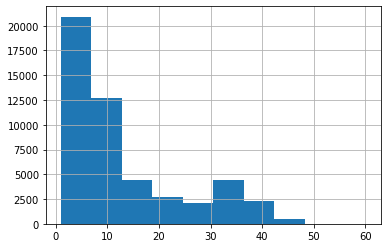

In [7]:
print(loan_m['term'].max())

loan_m.groupby('id').count().time.hist()
print(loan_m.groupby('id').count().time.max())  

#the max Y_x we could have, we have data until month 100, but Y_max 72, predit the survival in next 6 years at monthly rate.

Iteration 28: norm_delta = 0.00000, step_size = 1.00000, ll = -180110.03549, newton_decrement = 0.00000, seconds_since_start = 70.6Convergence completed after 28 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 622219 periods, 49982 subjects, 15153 events>

In [8]:
from data_preprocess import *
feature_list = cox_var

In [9]:
data_process = preprocess_data(data_original =loan_m[loan_m.id < 200], feature_list = feature_list,)

In [10]:
DATA, MASK, data_mi, pat_info = data_process.preprocess()

ValueError: Grouper for 'id' not 1-dimensional

In [ ]:
DATA[0].shape

# RNN 

In [ ]:
# first neural network with keras tutorial
import tensorflow as tf
from tensorflow import keras as keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from datetime import datetime


In [ ]:
from utils_layer import *
n_timesteps =  DATA[0].shape[1]
print(n_timesteps)

l_RNN = RNN_layer(n_timesteps = n_timesteps, n_features = 7, rnn_units = n_timesteps, n_layer_rnn = 2)
IN_ = tf.keras.Input(shape=(n_timesteps, 7))

In [ ]:
outputs_1 = Sequential(l_RNN)(IN_)
x = attention()(outputs_1)
FNN = Sequential(FNN_layer(128, n_layer_dense = 1, activation_fn_dense = None, 
drop = True, r_drop = 0.4))
x = FNN(x)
outputs_2 = Dense(n_timesteps, activation='softmax', trainable=True)(x)
# build path to get sequence output and pi
M = keras.Model(inputs = IN_, outputs = [outputs_1, outputs_2])

In [ ]:
M.summary()

In [ ]:
#compute loss
#log_likelihood
def Prob_Surv(batch_index, data, mask, OUT_h_i, RNN_net = True, ):
    if RNN_net == True:
        (mask_1, mask_2, mask_3) = mask #MASK[0]
    
    mask_1 = tf.constant(mask_1[batch_index], shape = OUT_h_i.shape, dtype = 'float32')
    mask_2 = tf.constant(mask_2[batch_index], shape = OUT_h_i.shape, dtype = 'float32')
    mask_3 = tf.constant(mask_3[batch_index], shape = OUT_h_i.shape, dtype = 'float32')

    h_i = tf.reshape(tf.math.multiply(OUT_h_i, mask_1), mask_1.shape, name='h_i')
    S_t = tf.reshape(tf.math.reduce_prod(1- h_i, axis=1, keepdims=False, name='S_i'),
    (len(batch_index), 1))

    h_last = tf.reduce_sum(tf.reshape(tf.math.multiply(OUT_h_i, mask_2), mask_2.shape), axis = 1) 
    # shape (batch_size, 1) unwanted points == 0
    mul_h = tf.math.reduce_prod(1- tf.math.multiply(OUT_h_i, mask_3, mask_3.shape,), axis=1)  # (50, 1)
    p_il = tf.reshape(tf.math.multiply(h_last, mul_h), (len(batch_index), 1))

    return p_il, S_t

In [ ]:
def loss_likelihood(p_i, Prob, S_t, 
censoring_status, payoff_status, alpha = 0.6):   # censoring case == 0
    #weigths_censored   =  
    #weigths_uncensored = 
    
    # censored data
    l_censored = tf.math.add(tf.math.subtract(1, p_i), tf.math.multiply(p_i, S_t))
    l_censored = l_censored[censoring_status == 0]
    l_censored = tf.reduce_sum(
        tf.math.log(l_censored)
        )
        
    # uncensored data, true event time z
    l_uncensored = tf.math.multiply(p_i, Prob)
    l_uncensored = l_uncensored[censoring_status == 1]
    l_uncensored = tf.reduce_sum(
        tf.math.log(l_uncensored)
        )

    l_mixture = l_censored + l_uncensored

    # punishment of t>z
    l_uncensored_2 = tf.reduce_sum(
        tf.math.log((1-S_t)[censoring_status == 1])
        )
    
    l_censored_2 = tf.reduce_sum(
        tf.math.log((S_t)[censoring_status == 0])
        )

    l_c = l_uncensored_2 + l_censored_2 
    return -(alpha*l_mixture + (1-alpha)*l_c) 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
def train_step(batch_index, input, censoring_status, payoff_status):
    with tf.GradientTape() as tape:
        # make a prediction using the model and then calculate the
        # loss
        OUT_h_i_ = tf.math.sigmoid(path_1(inputs = input)[:,-1, :])  #output shape (batch_size, timestep, 1)
        OUT_p_i_ = path_RNN(inputs = input)  #output shape (batch_size, 1)
        p_il, S_t = Prob_Surv(batch_index, input, MASK[0], OUT_h_i_,)
        loss_1 = loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status, alpha = 0.6)
        
        #loss = tf.math.sqrt(abs(loss_1))*0.3 + loss_2*0.7
    # moniter susceptible ratio for default cases:
    acc   = tf.keras.metrics.AUC(int(len(censoring_status)/2))
    acc.update_state(censoring_status[censoring_status + payoff_status == 1], 
        OUT_p_i_[censoring_status + payoff_status == 1]
        )

    gradients = tape.gradient(loss_1, path_RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, path_RNN.trainable_variables))

    return acc.result().numpy(), loss_1.numpy()

#def test_step():


In [ ]:
num_epochs = 50
train_loss_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_avg.reset_states()
    for i in range(1200):
        batch_index = range(i*15, i*15 + 15)
        input = DATA[0][batch_index]
        censoring_status = DATA[2][batch_index]
        payoff_status    = DATA[3][batch_index]

        score, loss,  = train_step(batch_index, input, censoring_status, payoff_status)

        epoch_loss_avg.update_state(loss)
        train_accuracy_results.append(score)
        train_loss_results.append(epoch_loss_avg.result())
        
        if i % 300 == 0:
            print("it {:03d}: Loss: {:.3f}, AUC: {:.3%}".format(i, epoch_loss_avg.result(), tf.math.reduce_mean(train_accuracy_results[-300:])))
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
     epoch_loss_avg.result(),
     tf.math.reduce_mean(train_accuracy_results[-15000:])))
    print('===================================')

In [ ]:
pd.DataFrame(train_loss_results).to_csv('RNN_loss.csv')
pd.DataFrame(train_accuracy_results).to_csv('RNN_accuracy.csv')

In [ ]:
batch_index = range(-5000, 0)
input = DATA[0][batch_index]
censoring_status = DATA[2][batch_index]
payoff_status    = DATA[3][batch_index]

OUT_h_i_ = tf.math.sigmoid(path_1(inputs = input)[:,-1, :])  #output shape (batch_size, timestep, 1)
OUT_p_i_ = path_RNN(inputs = input)  #output shape (batch_size, 1)
p_il, S_t = Prob_Surv(batch_index, input, MASK[0], OUT_h_i_,)
loss_1 = loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status)

In [ ]:
acc   = tf.keras.metrics.AUC(int(len(censoring_status)/2))
acc.update_state(censoring_status[censoring_status + payoff_status == 1], 
        OUT_p_i_[censoring_status + payoff_status == 1]
        )
acc.result()

In [ ]:
censoring_status[censoring_status + payoff_status == 1][:20]

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i.numpy() for i in train_loss_results])

In [ ]:
from lifelines.utils import concordance_index
def c_index(batch_index, OUT_h_i_, pat_info, RNN = False):
    pil_matrix = np.zeros(OUT_h_i_.shape)
    pil_matrix[:, 0] = OUT_h_i_[:, 0]
    for i in range(n_timesteps):
        if i == 0:
            pass
        else:
            temp_h = OUT_h_i_[:, i]
            temp_h_1 = tf.math.subtract(1, OUT_h_i_)[:, :i-1]
            h = tf.reduce_prod(temp_h_1, axis = 1)
            pil_matrix[:, i] = tf.math.multiply(temp_h, h).numpy()

    names = batch_index
    events = pat_info[:, 3][batch_index]
    pred_cindex = []
    preds_t = []
    for i in [12, 24, 36, 48]:
        preds = tf.math.argmax(pil_matrix[:, :i], axis = 1).numpy()
        res = concordance_index(events, preds)
        pred_cindex.append(res)
        preds_t.append(preds)
    return pred_cindex, preds_t, pil_matrix, 

In [ ]:
pred_cindex, preds_t, pil_matrix = c_index(batch_index, OUT_h_i_, pat_info, RNN = False)

In [ ]:
for i in [12, 24, 36, 48]:
    events = pat_info[:, 3][batch_index]
    preds = tf.math.argmax(OUT_h_i_[:, :i], axis = 1).numpy()
    print(concordance_index(events, preds))

In [ ]:
x = tf.nn.softmax(pil_matrix, axis = 1)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
for i in range(len(OUT_h_i_)):
    plt.plot(range(n_timesteps), x[i,:])

In [ ]:
id = 17
plt.plot(range(n_timesteps), b[id,:])
print(pat_info[:, 3][id])
print(censoring_status[id])